In [1]:
# импотируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.callbacks import History
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.5 MB/s eta 0:00:00


In [2]:
df = pd.read_csv("train.csv")

In [3]:
# выводим общую информацию о датасете
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162185 entries, 0 to 162184
Data columns (total 22 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   request_ts       162185 non-null  int64  
 1   user_id          162185 non-null  object 
 2   referer          162185 non-null  object 
 3   geo_id           162185 non-null  int64  
 4   component0       162185 non-null  int64  
 5   component1       162185 non-null  int64  
 6   component2       162185 non-null  int64  
 7   component3       162185 non-null  int64  
 8   component4       162185 non-null  int64  
 9   component5       162185 non-null  int64  
 10  component6       162185 non-null  int64  
 11  component7       162185 non-null  int64  
 12  component8       162185 non-null  int64  
 13  component9       162185 non-null  int64  
 14  country_id       162185 non-null  object 
 15  region_id        162184 non-null  object 
 16  timezone_id      162184 non-null  obje

In [4]:
# удаляем пустые строки
df = df.dropna()

In [5]:
df.head()

,request_ts,user_id,referer,geo_id,component0,component1,component2,component3,component4,component5,...,component8,component9,country_id,region_id,timezone_id,browser,browser_version,os,os_version,target
0,1701011363,fb858e8e0a2bec074450eaf94b627fd3,https://9b48ee5/,4799,11731,4045,22213,-1184,-8992,9381,...,-899,16817,c31b4e,470e75,f6155e,Chrome Mobile,119.0.0,Android,10,0.0
1,1700986581,46a5f128fd569c764a92c2eaa788095e,https://9b48ee5/,8257,11731,4045,22213,-1184,-8992,9381,...,-899,16817,c31b4e,44520b,e56e80,Chrome Mobile,111.0.0,Android,10,0.0
2,1701011071,5a74e9ac53ffb21a20cce117c0ad77ba,https://9634fd0/1409e548,3150,12498,2451,10304,-6380,11608,3106,...,3347,21870,c31b4e,616bb9,af47f1,Yandex Browser,20.12.5,Android,11,0.0
3,1700992803,af735816ca19115431ae3d89518c8c91,https://9b48ee5/,2740,11731,4045,22213,-1184,-8992,9381,...,-899,16817,c31b4e,3c9dca,e56e80,Chrome Mobile,119.0.0,Android,10,0.0
4,1701021666,364f0ae0a3f29a685c4fb5bae6033b9a,https://9b48ee5/,4863,11731,4045,22213,-1184,-8992,9381,...,-899,16817,c31b4e,776e76,10b7947,Yandex Browser,18.11.1,Android,4.4.4,0.0


Из данных видим, что есть очевидно лишний столбец user_id, который не поможет при обучении, данные из столбца geo_id требует перевода в тип object, также приведем к целочисленному типу target, приведем к строковому типу данных referer для последующей обработки

In [6]:
df.drop(columns=['user_id'], inplace=True)
df['geo_id'] = df["geo_id"].astype("object")
df['target'] = df["target"].astype("int64")
df = df[df['referer'].apply(lambda x: isinstance(x, str))]

Разделим данные из колонки referer на domain и path - чтобы отдельно обрабатывать информацию об основной странице и отдельно - о вкладках, к которые переходил пользователь. Таким образом, удобнее обрабатывать данные о том, переходил ли пользователь куда-то кроме главной страницы. После со здания двух новых колонок удаляем referer

In [7]:
def split_referer(referer):
    referer = referer[8::]
    parts = referer.split('/', 2)
    domain = parts[0]
    if len(parts) > 1 and parts [1]:
        path = parts[1]
    else:
        path = 'nopath'
    return domain, path

In [8]:
df[['domain', 'path']] = df['referer'].apply(split_referer).tolist()

In [9]:
df.drop(columns=['referer'], inplace=True)

Поскольку категориальные признаки нужно будет переводить в числовые и более правильным видится метод OneHotEncoding (ввиду отсутствия естественного порядка в данных (за исключением разве что browser_version и os_version, но для этого нужна дополнительная предобработка, так как разные версии относятся еще и к разным видам), то необходимо посмотреть на количество возможных новых столбцов. Как видим из статистики, данные нужно сокращать (в противном случае размер датасета становится около 9 Гб и не позволяет обучить модель на имеющихся ресурсах). Я применил следующее: обрезал номера версий ОС и браузеров до основного номера, по признакам 'domain', 'path', 'region_id', 'geo_id', 'browser_version', 'timezone_id' - редкие категории (количество которых менее 100) и по признаку 'os_version' (если количество менее 30) заменил на искуствнное значение 0

In [10]:
columns_to_check = ['domain', 'path', 'country_id', 'geo_id', 'region_id', 'timezone_id', 'browser_version', 'os', 'os_version']
unique_counts = df[columns_to_check].agg('nunique')
print(unique_counts)

domain              3174
path               45346
country_id            12
geo_id              1648
region_id            245
timezone_id           59
browser_version      945
os                     7
os_version           177
dtype: int64


In [11]:
col_for_del = ['browser_version', 'os_version']
for column in col_for_del:
    df[column] = df[column].astype(str).str.split('.').str[0]

In [12]:
for column in columns_to_check:
    print(f"Статистика по столбцу '{column}':")
    value_counts = df[column].value_counts()
    print(value_counts)
    print("-" * 30)

Статистика по столбцу 'domain':
domain
72879b4    15279
6a81948    13561
8807153     8795
9f1218f     7316
9b08d64     7286
           ...  
7b4f1c2        1
a77b2a5        1
93e5a50        1
ae26de9        1
6a4ffd0        1
Name: count, Length: 3174, dtype: int64
------------------------------
Статистика по столбцу 'path':
path
nopath      60796
16658dd6      916
172507b2      883
175de82a      736
1458ef49      627
            ...  
133a89b7        1
134a4a49        1
17cbece0        1
13ff28d0        1
1473937a        1
Name: count, Length: 45346, dtype: int64
------------------------------
Статистика по столбцу 'country_id':
country_id
c31b4e     142415
121db33      8512
af12ca       3034
b98648       2404
1234f1d      2357
ac5671       1892
110628b       479
eba88b        420
e37756        416
103bf7d       147
122be0f        94
ff9306         14
Name: count, dtype: int64
------------------------------
Статистика по столбцу 'geo_id':
geo_id
3663    28311
2521    12509
4106     51

In [13]:
def rare_100(df, columns):
    for col in columns:
        value_counts = df[col].value_counts()
        rare_values = value_counts[value_counts <= 100].index
        df[col] = df[col].replace(rare_values, 0)
    return df

def rare_os(df, columns):
    for col in columns:
        value_counts = df[col].value_counts()
        rare_values = value_counts[value_counts <= 30].index
        df[col] = df[col].replace(rare_values, 0)
    return df

In [16]:
df = rare_100(df, ['domain', 'path', 'region_id', 'geo_id', 'browser_version', 'timezone_id'])
df = rare_os(df, ['os_version'])

<ipython-input-13-d5f553256292>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(rare_values, 0)


In [18]:
for column in columns_to_check:
    print(f"Статистика по столбцу '{column}':")
    value_counts = df[column].value_counts()
    print(value_counts)
    print("-" * 30)

Статистика по столбцу 'domain':
domain
0          22467
72879b4    15279
6a81948    13561
8807153     8795
9f1218f     7316
           ...  
81234ad      108
60eaef2      106
a771224      106
bde0f1c      102
805f010      101
Name: count, Length: 151, dtype: int64
------------------------------
Статистика по столбцу 'path':
path
0           86431
nopath      60796
16658dd6      916
172507b2      883
175de82a      736
            ...  
16e1a7c7      103
159f800a      102
172d5d6b      101
151268f0      101
1228a86b      101
Name: count, Length: 71, dtype: int64
------------------------------
Статистика по столбцу 'country_id':
country_id
c31b4e     142415
121db33      8512
af12ca       3034
b98648       2404
1234f1d      2357
ac5671       1892
110628b       479
eba88b        420
e37756        416
103bf7d       147
122be0f        94
ff9306         14
Name: count, dtype: int64
------------------------------
Статистика по столбцу 'geo_id':
geo_id
3663    28311
0       18145
2521    12509
4

Для категориальных признаков применяем OneHotEncoding

In [19]:
features_to_encode = ['domain', 'path', 'country_id', 'region_id', 'os', 'os_version', 'browser', 'timezone_id', 'browser_version']

In [22]:
df = pd.get_dummies(df, columns=features_to_encode, prefix=features_to_encode)

In [24]:
def convert_bool_columns_to_int(df):
    for column in df.columns:
        if df[column].dtype == 'bool':
            df[column] = df[column].astype(int)
    return df

df = convert_bool_columns_to_int(df)

Создаем отдельные датафреймы с обучающими данными и с целевым признаком. Разделяем данные на обучающую, валидационную и тестовую выборки, преобразуем их к формату, читаемому моделью TabNet

In [ ]:
df.to_csv('/content/dfdot.csv', sep=';', encoding='utf-8')
df.to_csv('/content/dfnedot.csv', sep=',', encoding='utf-8')

In [25]:
X = df.drop('target', axis=1)
y = df['target']

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

In [28]:
X_train = X_train.values
X_valid = X_valid.values
X_test = X_test.values
y_train = y_train.values
y_valid = y_valid.values
y_test = y_test.values

Обучение проводилось с разными вариациями гиперпараметров (в частности, max_epochs, batch_size, learning rate, n_d и n_a, patience) - примеры вынесены в отдельный файл. Ниже представлена итоговая версия, с параметрами, показавшими лучший результат (все значения дефолтные кроме количества эпох и размера батча)

In [30]:
clf = TabNetClassifier()
clf.fit(
  X_train, y_train,
  eval_set=[(X_valid, y_valid)],
  eval_metric=['accuracy'],
  batch_size=512,
  max_epochs=50,
  callbacks=[]
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.69207 | val_0_accuracy: 0.53057 |  0:00:42s
epoch 1  | loss: 0.55918 | val_0_accuracy: 0.52924 |  0:01:24s
epoch 2  | loss: 0.50933 | val_0_accuracy: 0.52869 |  0:02:07s
epoch 3  | loss: 0.49107 | val_0_accuracy: 0.63652 |  0:02:50s
epoch 4  | loss: 0.47607 | val_0_accuracy: 0.77967 |  0:03:33s
epoch 5  | loss: 0.46779 | val_0_accuracy: 0.7981  |  0:04:15s
epoch 6  | loss: 0.45865 | val_0_accuracy: 0.80327 |  0:04:59s
epoch 7  | loss: 0.45387 | val_0_accuracy: 0.80574 |  0:05:42s
epoch 8  | loss: 0.44997 | val_0_accuracy: 0.80434 |  0:06:24s
epoch 9  | loss: 0.44681 | val_0_accuracy: 0.80971 |  0:07:07s
epoch 10 | loss: 0.44258 | val_0_accuracy: 0.80886 |  0:07:50s
epoch 11 | loss: 0.44099 | val_0_accuracy: 0.81146 |  0:08:32s
epoch 12 | loss: 0.43774 | val_0_accuracy: 0.81156 |  0:09:15s
epoch 13 | loss: 0.43588 | val_0_accuracy: 0.8118  |  0:09:57s
epoch 14 | loss: 0.43444 | val_0_accuracy: 0.81167 |  0:10:39s
epoch 15 | loss: 0.43191 | val_0_accuracy: 0.81061 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Получаем историю обучения и строим график

In [31]:
history = clf.history
train_loss = history['loss']
valid_accuracy = history['val_0_accuracy']

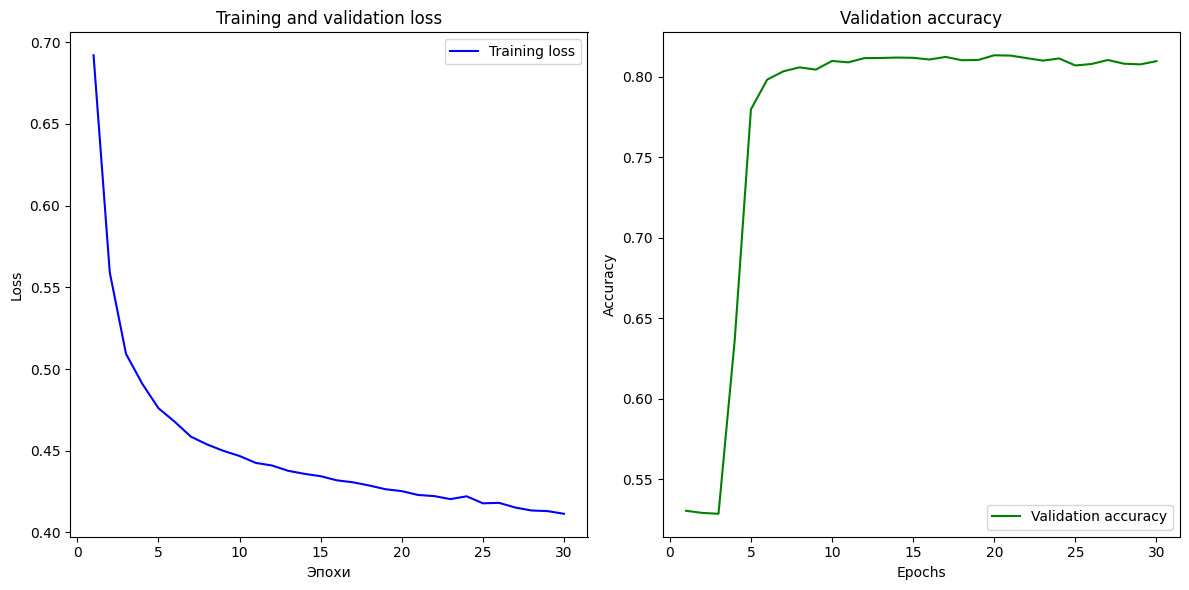

In [32]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.title('Training and validation loss')
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, valid_accuracy, 'g', label='Validation accuracy')
plt.title('Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
preds = clf.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy на тестовых данных: {accuracy:.4f}")

Accuracy на тестовых данных: 0.8152


In [34]:
feature_names = list(X.columns)

In [35]:
def get_top_features(clf, X_test, feature_names, num_top_features=20):
    explain_matrix, masks = clf.explain(X_test)

    # агрегируем важность признаков (среднее по всем образцам)
    feature_importance = np.mean(explain_matrix, axis=0)

    # получаем индексы и сортируем по убыванию
    important_indices = np.argsort(feature_importance)[::-1]

    # получаем названия признаков и их важность
    top_features_indices = important_indices[:num_top_features]
    top_features = pd.Series(feature_importance[top_features_indices], index=np.array(feature_names)[top_features_indices]).sort_values(ascending=False)

    return top_features

In [36]:
top_features = get_top_features(clf, X_test, feature_names)
print("Топ 7 наиболее важных признаков:")
print(top_features)

Топ 7 наиболее важных признаков:
path_169b036d                    0.443266
browser_Edge Mobile              0.428011
timezone_id_af47f1               0.374661
browser_version_116              0.199530
domain_826d8f3                   0.191441
domain_60d1206                   0.106385
domain_805f010                   0.086161
path_13016c97                    0.084882
os_version_6                     0.044260
browser_Instagram                0.040265
country_id_ff9306                0.032264
browser_Chrome Mobile WebView    0.030644
domain_77ed592                   0.027659
domain_635e50c                   0.024038
domain_94dc6b2                   0.020531
browser_version_78               0.015994
browser_MiuiBrowser              0.007569
domain_9836ce2                   0.002491
browser_version_21               0.001847
os_version_15                    0.001552
dtype: float64


Несмотря на то, что важность признаков продемонстрирована с учетом разделения данных на отдельные столбцы после применения метода get_dummies, можно сделать вывод, что наибольший вклад оказывают такие признаки из изначального датасета как domain, path, browser, browser_version, os_version

In [37]:
saving_path_name = "/content/tabnet_model81"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at /content/tabnet_model81.zip
